In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/training_data/REVL COOF VALUATION 07-2023.csv')

df = df[[c for c in df.columns if 'unnamed' not in c.lower()]]
x = [c.replace('\n','') for c in df.columns]
x = [c.replace(' ','_') for c in x]
x = [c.lower() for c in x]
df.columns = x
df['naics'] = df['naics'].astype(int)

df['term_yrs']=df['term']//12

x_df = df[['naics','loan_spread','loan_rate','strip_rate','original_balance','current_balance','term_yrs','term','age','rmos']]
y_df = df['valuation_multiple']

X = x_df
y = y_df

def get_naics_dummies(in_df:pd.DataFrame)->pd.DataFrame:
    temp = in_df.copy()
    temp['is_hotel'] = 0
    temp.loc[temp['naics']==721110, 'is_hotel'] = 1
    temp.columns = [str(c) for c in temp.columns]
    return temp.drop(columns='naics')

# Create dummy columns with all the categories observed in the entire dataset
X = get_naics_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()

scaler = StandardScaler()

scaler.fit_transform(X_train, y_train)

print(X_train)

# Train the model on the training data
reg_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = reg_model.predict(X_test)

     loan_spread  loan_rate  strip_rate  original_balance  current_balance   
464       0.0275     0.1125     0.03535         503385.22        503385.22  \
0         0.0275     0.1125     0.02555        4486841.50       4486841.50   
11        0.0225     0.1075     0.02605        3666846.09       3666846.09   
448       0.0200     0.1050     0.00980        3706889.74       3706889.74   
22        0.0150     0.1000     0.01305        2658171.05       2658171.05   
..           ...        ...         ...               ...              ...   
71        0.0275     0.1125     0.03105         261025.34        261025.34   
106       0.0125     0.0975     0.00480        3112500.00       3112500.00   
270       0.0200     0.1050     0.01040         401402.12        391096.33   
435       0.0150     0.1000     0.00480        1650000.00       1650000.00   
102       0.0200     0.1050     0.01780         367875.00        367875.00   

     term_yrs   term   age   rmos  is_hotel  
464      25.0  31

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test data
y_pred = reg_model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)


Mean Squared Error (MSE): 0.01993100194898381
R-squared: 0.8310075154573479


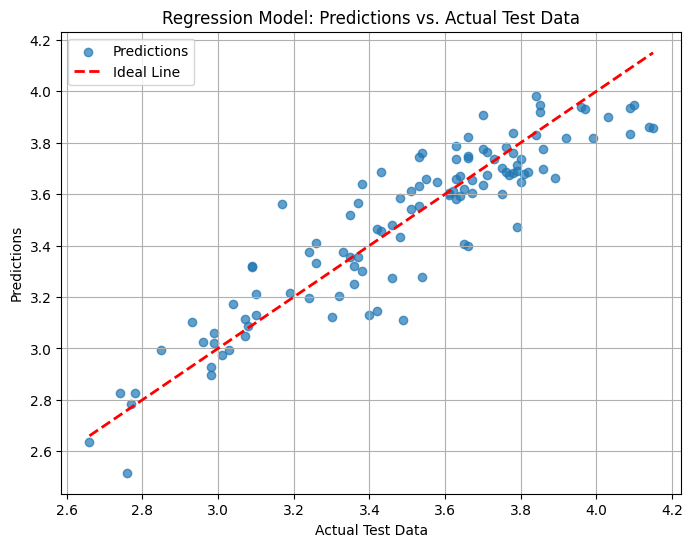

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the predictions vs the actual test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal Line')
plt.xlabel('Actual Test Data')
plt.ylabel('Predictions')
plt.title('Regression Model: Predictions vs. Actual Test Data')
plt.legend()
plt.grid(True)
plt.show()


Feature Importance Data:
            Feature   Coefficient  Absolute_Coefficient
0       loan_spread  2.267860e+00          2.267860e+00
1         loan_rate  2.267860e+00          2.267860e+00
2              rmos  2.423958e-01          2.423958e-01
3              term -2.277395e-01          2.277395e-01
4          is_hotel -2.145963e-01          2.145963e-01
5               age  2.067398e-01          2.067398e-01
6          term_yrs -9.914455e-02          9.914455e-02
7        strip_rate -3.850321e-02          3.850321e-02
8   current_balance -7.882571e-07          7.882571e-07
9  original_balance  7.837273e-07          7.837273e-07


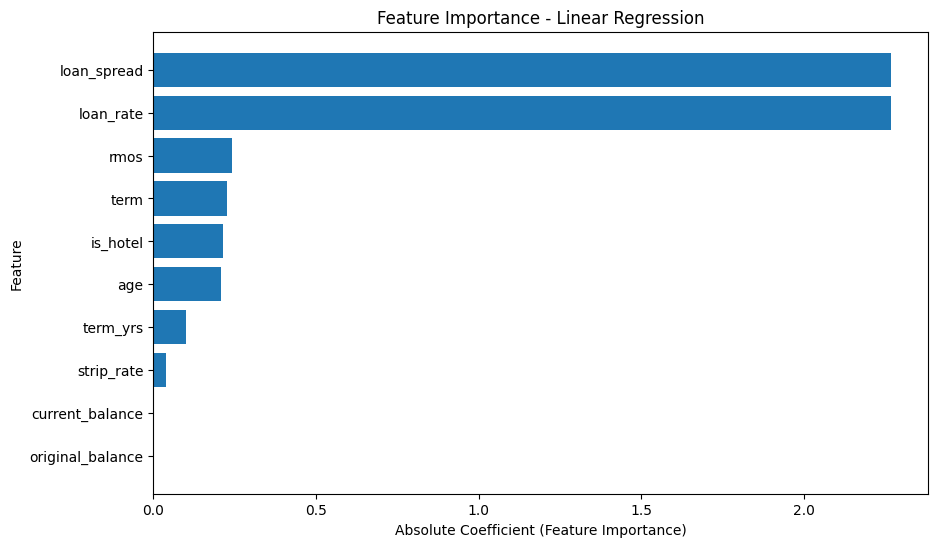

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already trained the 'reg_model' linear regression model

# Get the coefficients (weights) of the linear regression model
coefficients = reg_model.coef_

# Get the feature names
feature_names = X.columns

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the absolute coefficients (feature importance)
feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()

# Sort the features based on their absolute coefficients to get feature importance
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False).reset_index(drop=True)

# Display the DataFrame containing feature importance data
print("Feature Importance Data:")
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute_Coefficient'])
plt.xlabel('Absolute Coefficient (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance - Linear Regression')
plt.gca().invert_yaxis()
plt.show()


In [5]:
col_order = X.columns

In [7]:
fhn = pd.read_csv('../data/fhn_8.23.23.csv')

fhn_1 = fhn[fhn.columns[1:]]

fhn_1['is_hotel'] = 0

fhn_1.loc[fhn_1['naics'] == ('721110'), 'is_hotel'] = 1

fhn_1 = fhn_1[fhn_1.columns[1:]]

fhn_1['term_yrs'] = fhn_1['term'] // 12

fhn_1 = fhn_1[col_order]

In [8]:
truist_pred = reg_model.predict(fhn_1)

In [9]:
fhn['predicted_mult'] = truist_pred

In [10]:
fhn.to_csv('../data/fhn_predictions.csv')